In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.datasets import Multi30k
from torchtext.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np
import matplotlib

import random
import math
import time
import random
from yellowbrick.text import TSNEVisualizer
from sklearn.decomposition import PCA

#TODO try TSNE instead of PCA

In [2]:
HID_DIM = 64
ENC_LAYERS = 1
DEC_LAYERS = 1
ENC_HEADS = 1
DEC_HEADS = 1
ENC_PF_DIM = 128
DEC_PF_DIM = 128
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

def get_head_count():
    return ENC_HEADS

def get_row_count():
    return 1

def get_col_count():
    return 1

In [3]:
class StepLogger():
    def __init__(self,capacity):
        self.tensor_datas = {}        
        self.capacity = capacity
        self.added_labels = []
        
    
    def add_info(self,tensor_data,tensor_label):
        if tensor_label not in self.added_labels:
            self.added_labels.append( tensor_label )
        
        if tensor_label in self.tensor_datas.keys():
            current_arr = self.tensor_datas.get(tensor_label)
            if len(current_arr) < self.capacity:
                current_arr = self.tensor_datas.get(tensor_label, [])
                current_arr.append(tensor_data)
        else:
            self.tensor_datas[tensor_label] = [tensor_data]
    
    def get_default_summary(self,show_data=False,summary_count=1):
        self.get_summary(self.added_labels,show_data,summary_count)
        
    def get_summary(self,labels,show_data=False,summary_count=1):
        print("summary_count",summary_count,"   self.capacity ",self.capacity)
        count = 0
        values = []
        for i in range(summary_count):
            #print(i," ------------------------------------------------")
            for l in labels:
                if i < len(self.tensor_datas.get(l)):
                    label_data = self.tensor_datas.get(l)[i]
                    values.append(label_data)
                    print(l)
                    if torch.is_tensor(label_data):
                        print( list(label_data.size() ) )
                    if not show_data and not torch.is_tensor(label_data):
                        print(label_data)
                    if show_data:    
                        print(label_data)
        return values              
                    
loggers = {}                    
current_logger = StepLogger(100)   
def add_new_logger(logger_label):
    global current_logger
    if logger_label in loggers.keys() :
        print("using existing logger")
        current_logger = loggers[logger_label]
    else:    
        loggers[logger_label]  = StepLogger(20)
        current_logger = loggers[logger_label]
    

def add_infos(datas,labels,labels_prefix=""):
    #print( id(current_logger))
    for i in range(len(datas)):
        final_label = labels_prefix+"@"+labels[i]
        current_logger.add_info(datas[i],final_label.strip())
    
#add_info   tensor_data,tensor_label                  currentLogger.get_default_summary(show_data=False)

data_pipeline = []
pipeline_enabled = True
def disable_pipeline():
    global pipeline_enabled
    pipeline_enabled = False

def enable_pipeline():
    global pipeline_enabled
    pipeline_enabled = True
    
def add_pipeline_info(label,data):
    if pipeline_enabled:
        data_pipeline.append( (label,data) )
    

In [4]:
a = 2
def seta():
    global a
    a = 3
print(a)
seta()
print(a)



2
3


In [5]:
#!pip install torchtext
#!pip install spacy

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
#spacy_en = spacy.load('en')
spacy_en = spacy.load("en_core_web_sm")

In [8]:
#tok = spacy.load("en_core_web_sm")
#tokde = spacy.load("de_core_news_sm")
import de_core_news_sm
spacy_de = de_core_news_sm.load()

In [9]:
spacy_de.tokenizer("i mochte lesen")

i mochte lesen

In [10]:
#!python -m spacy download de


In [11]:
#spacy_de = spacy.load('de')

In [12]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

In [13]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

In [14]:
tabular_set = torchtext.data.TabularDataset(
path='D:/data8/eng_de3.csv', format='csv',
fields=[('src', SRC),
        ('trg', TRG)])

In [15]:
#dump a sample
print(tabular_set[0].src)
print(tabular_set[0].trg)


['i', 'want', 'to', 'eat', 'bread']
['ich', 'mochten', 'brot', 'essen']


In [16]:
#TODO can generate different items for each
#Real line in tutorial
#train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), fields = (SRC, TRG))
train_data, valid_data, test_data = tabular_set ,tabular_set, tabular_set

In [17]:
#all of our vocublary is used at least 2 times
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

In [18]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device


device(type='cpu')

In [19]:
#our tranining size is so small so batch size will also be small
BATCH_SIZE = 8


In [20]:
train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x:  len(x.src),
     device = device)


In [21]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask,is_appy_attention):
    
        add_infos([src],["src_source"],"Encoder")
        add_pipeline_info(label="Encoder->attention",data=src)
        #src = [batch size, src len]
        #src_mask = [batch size, src len]
        #print("Encoder src",src)
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        add_infos([src,pos],["src","pos"],"Encoder")   
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask,is_appy_attention)
            
        
        add_infos([src],["src_final"],"Encoder")    
        #src = [batch size, src len, hid dim]
            
        return src

In [22]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"encoder")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask,is_appy_attention):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, src len]
                
           
        #self attention
        _src, sattention = self.self_attention(src, src, src,is_appy_attention, src_mask) #return x, attention
        
        #dropout, residual connection and layer norm
        src2 = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src2 = self.positionwise_feedforward(src2)
        
        #dropout, residual and layer norm
        src3 = self.ff_layer_norm(src + self.dropout(_src2))
        
        add_infos([_src,src2,_src2,src3,src_mask,sattention],["_src","src2","_src2","src3","src_mask","sattention"],"EncoderLayer")
        #src = [batch size, src len, hid dim]
        
        return src3

In [23]:
class MultiHeadAttentionLayer(nn.Module):
    #since this layer is common while logging there must be a label to differantiate labels
    def __init__(self, hid_dim, n_heads, dropout, device,layer_label):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        #TODO head_dim is encoding per head so ,hid_dim must divide n_heads
        self.head_dim = hid_dim // n_heads
        self.layer_label = layer_label
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        add_infos([self.hid_dim,self.n_heads,self.head_dim],["hid_dim","n_heads","head_dim"],self.layer_label)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value,is_appy_attention, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        
        add_infos([Q,K,V],["Q","K","V"],self.layer_label)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
            
        
        
        attention = torch.softmax(energy, dim = -1)
        
        add_pipeline_info(label=self.layer_label+"@QKV",data=[Q,K,V,mask,energy,attention])       
        
        ### attention is a weight over dimensions
        if not is_appy_attention:
            #print("old attention",attention.shape)
            #print("old attention",attention)
        
            #normally distributed literally means no attention
            #attention = torch.tensor(np.full(attention.shape, 1/attention.shape[3]),dtype=torch.float32 )
            #just pay attention to beginning
            #at last dimension shape is flat 1, 2, 1, 1
            if attention.shape[3] > 2: 
                real_shape = attention.shape
                att1 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], 3), 1/3) ,dtype=torch.float32 )
                att2 = torch.tensor(np.full((real_shape[0], real_shape[1], real_shape[2], real_shape[3] - 3), 1/7) ,dtype=torch.float32 )
                att3 = torch.cat( (att1,att2),3 )
                attention = torch.softmax(att3, dim = -1)
            
            
            #print("new attention",attention)
                
        #attention = [batch size, n heads, query len, key len]
                
        x1 = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x2 = x1.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x3 = x2.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x4 = self.fc_o(x3)
        
        #x = [batch size, query len, hid dim]
        
        add_infos([energy,mask,attention],["energy","mask","attention"],self.layer_label)
        add_infos([x1,x2,x3,x4],["x1","x2","x3","x4"],self.layer_label)
        
        return x4, attention

In [24]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x1 = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x2 = self.fc_2(x1)
        
        #x = [batch size, seq len, hid dim]
        add_infos([x1,x2],["x1","x2"],"PositionwiseFeedforwardLayer")
        
        return x2

In [25]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,is_appy_attention=False):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask,is_appy_attention)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        add_infos([pos,trg,output,attention],["pos","trg","output","attention"],"Decoder")
        #output = [batch size, trg len, output dim]
            
        return output, attention

In [26]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_self")
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device,"decoder_encoder_attention")
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask,is_appy_attention):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, trg len]
        #src_mask = [batch size, src len]
        
        #self attention
        _trg1, _ = self.self_attention(trg, trg, trg,is_appy_attention, trg_mask)
        
        #dropout, residual connection and layer norm
        trg2 = self.self_attn_layer_norm(trg + self.dropout(_trg1))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg2, attention = self.encoder_attention(trg2, enc_src, enc_src,is_appy_attention, src_mask)
        
        #dropout, residual connection and layer norm
        trg3 = self.enc_attn_layer_norm(trg2 + self.dropout(_trg2))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg3 = self.positionwise_feedforward(trg3)
        
        #dropout, residual and layer norm
        trg4 = self.ff_layer_norm(trg3 + self.dropout(_trg3))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        add_infos([_trg1,trg2,_trg2,trg3,_trg3,trg4,attention,trg_mask, src_mask],["_trg1","trg2","_trg2","trg3","_trg3","trg4","attention","trg_mask", "src_mask"],"DecoderLayer")
        
        return trg4, attention

In [27]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg,is_appy_attention):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        #print("Seq2Seq src",src)
        enc_src = self.encoder(src, src_mask,is_appy_attention)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask,is_appy_attention)
        
        add_infos([src_mask,trg_mask,enc_src,output,attention],["src_mask","trg_mask","enc_src","output","attention"],"Seq2Seq")
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [28]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)


enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [29]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [30]:
print("SRC_PAD_IDX",SRC_PAD_IDX)
print("TRG_PAD_IDX",TRG_PAD_IDX)
print(SRC.vocab.itos[10])
print(SRC.vocab.stoi[SRC.vocab.itos[10]])

SRC_PAD_IDX 1
TRG_PAD_IDX 1
to
10


In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 99,857 trainable parameters


In [32]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [33]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(18, 64)
    (pos_embedding): Embedding(100, 64)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=64, out_features=64, bias=True)
          (fc_k): Linear(in_features=64, out_features=64, bias=True)
          (fc_v): Linear(in_features=64, out_features=64, bias=True)
          (fc_o): Linear(in_features=64, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=64, out_features=128, bias=True)
          (fc_2): Linear(in_features=128, out_features=64, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (dropout): Dr

In [34]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

In [35]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)


In [36]:
def train(model, iterator, optimizer, criterion, clip,is_appy_attention):
    
    model.train()
    
    epoch_loss = 0
    
    print("train1")
    
    for i, batch in enumerate(iterator):
        #print("train2",i,batch)
        
        
        src = batch.src
        trg = batch.trg
        
        #print("train src",src)
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1],is_appy_attention)
        
        
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        
        
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [37]:
def evaluate(model, iterator, criterion,is_appy_attention):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1],is_appy_attention)
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [38]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

In [39]:
import os
import gc
N_EPOCHS = 20
CLIP = 1
best_valid_loss = float('inf')

add_new_logger("training")


model_save_path = "D:/data8/tut6-model_en_de.pt"
model_to_train = model
for epoch in range(N_EPOCHS):
    gc.collect()
    if os.path.isfile(model_save_path) :
        print("loading model",model_save_path)
        #TODO
        #model_to_train.load_state_dict(torch.load(model_save_path))
    
    start_time = time.time()
    
    enable_pipeline()
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP,is_appy_attention=True)
    
    disable_pipeline()
    valid_loss = evaluate(model, valid_iterator, criterion,is_appy_attention=True)    
    
    end_time = time.time()
    
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    
    if valid_loss < best_valid_loss:
        print("saving model",model_save_path," with loss ",valid_loss)
        best_valid_loss = valid_loss
        torch.save(model_to_train.state_dict(), model_save_path)
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')    

loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  2.7248631954193114
Epoch: 01 | Time: 0m 0s
	Train Loss: 3.263 | Train PPL:  26.120
	 Val. Loss: 2.725 |  Val. PPL:  15.254
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  2.2440669298172
Epoch: 02 | Time: 0m 0s
	Train Loss: 2.704 | Train PPL:  14.943
	 Val. Loss: 2.244 |  Val. PPL:   9.432
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  1.95553297996521
Epoch: 03 | Time: 0m 0s
	Train Loss: 2.352 | Train PPL:  10.509
	 Val. Loss: 1.956 |  Val. PPL:   7.068
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with loss  1.7270442485809325
Epoch: 04 | Time: 0m 0s
	Train Loss: 2.205 | Train PPL:   9.073
	 Val. Loss: 1.727 |  Val. PPL:   5.624
loading model D:/data8/tut6-model_en_de.pt
train1
saving model D:/data8/tut6-model_en_de.pt  with

In [40]:
import pandas as pd
import seaborn as sns

def test_sentence(src,draw_charts,is_appy_attention=True):
    
    if isinstance(src,str):
        src = src.split(" ")
    logger_name = "".join(src)+str( random.randint(1,180001) )
    add_new_logger(logger_name)
    print(f'src = {src}')

    translation, attention,all_outputs = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=is_appy_attention)

    print(f'predicted trg = {translation}')
    output_words = translation
    output_words[len(output_words)-1] = "EOS"
    output_words = [ str(index+1)+")"+ word for index,word in enumerate(output_words)]
    df2 = pd.DataFrame(all_outputs,columns=["unk","pad","sos","eos"]+TRG.vocab.itos[4:],index=output_words)
    cm = sns.light_palette("blue", as_cmap=True)

    styled_df = df2.style.background_gradient(cmap=cm)
    if draw_charts:
        display(styled_df)    
        display_attention(src, translation, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())
    return loggers[logger_name],all_outputs




def show_on_vis_multi(new_input_embeddings,input_sentences,valid_sentences_embeddings,valid_sentences):
    #print("new_input_embedding",new_input_embedding)
    Xs = valid_sentences_embeddings
    Ys = valid_sentences
   
    if len(input_sentences)> 0 :
        input_sentences = [ "<<<"+s+">>>" for s in input_sentences]
        Xs = Xs+ [embed for embed in new_input_embeddings]
        Ys = Ys + input_sentences 
        
    #tsne = TSNEVisualizer(labels=Ys,title="How output of encoder looks",random_state=42)
    #result = tsne.fit_transform(np.array(Xs),Ys)
    #tsne = TSNEVisualizer()
    #result =tsne.fit_transform(np.array(Xs),Ys)
    
    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(Xs))

    #result = fitted.transformer_.fit_transform(np.array(Xs))
    #print("input_sentences",input_sentences)

    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(18.5, 10.5)

    #scatter result words
    plt.scatter(result[:, 0], result[:, 1])
    words = list(Ys)
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        #print("wordi",word,i,type(word))
        if word in input_sentences:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00ff')
        elif "eat" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            plt.annotate(word, xy=(result[i, 0], result[i, 1]),color='#ff00dd')
    plt.show()    
    

def get_color(word):
    cmap = plt.get_cmap('viridis')
    distinct_words = SRC.vocab.itos[4:]
    #print("distinct_words",len(distinct_words))
    colors = cmap(np.linspace(0, 1, len(distinct_words)))
    color_map = { w:colors[i] for i,w in enumerate(distinct_words) }
    #print("color_map",color_map)
    for distinct_word in distinct_words:
        if  word.find(distinct_word) == 0: #if starstwith
            #print("word color",word," --> ", color_map[distinct_word])
            return color_map[distinct_word]
    #print("colors",colors)
    return color_map[distinct_words[0]]
    
                
def map_on_2d(data_2d,words,exceptional_words=[],use_word_colors=False,fig_size=[19,11]):
    fig = matplotlib.pyplot.gcf()
    fig.set_size_inches(fig_size[0], fig_size[1])

    #scatter result words
    plt.scatter(data_2d[:, 0], data_2d[:, 1])
    
    
    
    #put an annotation on x,y cordinates for words
    #print("input_sentences",input_sentences)
    for i, word in enumerate(words):
        #print("wordi",word,i,type(word))
        if word in exceptional_words:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff' )
        elif use_word_colors:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color=get_color(word))
        elif "eat" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#0000ff')
        elif "drink" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#00ff00')
        elif "read" in word:
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff0000')     
        else:
            #print("else",word)
            #plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
            plt.annotate(word, xy=(data_2d[i, 0], data_2d[i, 1]),color='#ff00dd')
    plt.show()      

In [41]:
"abcde".find("ab")

0

In [87]:
cnt = 0
#count is 300 20 iterations so 15 per iteration
#36 items, 8 batchsize = 5 batch
#15 / 5 = 3
#3 is number of AttentionLayer stack
Qs = []
Ks = []
Vs = []
Ss = [] #sentences
Es = [] #energy
As = [] #attentions
for i in range(len(data_pipeline)):
    #print( data_pipeline[i][0] )
    current_label = data_pipeline[i][0]
    if "encoder@QKV" == current_label:
         cnt += 1
         Qs.append(data_pipeline[i][1][0])
         Ks.append(data_pipeline[i][1][1])
         Vs.append(data_pipeline[i][1][2])
         Es.append(data_pipeline[i][1][4])
         As.append(data_pipeline[i][1][5])
    if "Encoder->attention" == current_label:
         
         Ss.append(data_pipeline[i][1])

In [97]:
len(Ss)

100

In [95]:
print(Qs[0].shape)
print(Ks[0].shape)
print(Vs[0].shape)
print(Es[0].shape)
print(As[0].shape)
print(Qs[0][:,0,:,:].shape)
print(As[0][0])
print(Ss[0])


torch.Size([8, 1, 7, 64])
torch.Size([8, 1, 7, 64])
torch.Size([8, 1, 7, 64])
torch.Size([8, 1, 7, 7])
torch.Size([8, 1, 7, 7])
torch.Size([8, 7, 64])
tensor([[[0.0262, 0.0185, 0.4006, 0.0461, 0.1028, 0.4058, 0.0000],
         [0.0042, 0.3041, 0.0335, 0.0175, 0.3509, 0.2898, 0.0000],
         [0.0138, 0.5917, 0.0567, 0.0074, 0.0604, 0.2701, 0.0000],
         [0.0693, 0.0912, 0.1299, 0.2171, 0.4524, 0.0402, 0.0000],
         [0.0818, 0.0048, 0.1622, 0.0188, 0.6860, 0.0463, 0.0000],
         [0.2452, 0.0485, 0.0145, 0.0157, 0.4964, 0.1797, 0.0000],
         [0.4002, 0.0184, 0.0085, 0.4541, 0.1117, 0.0071, 0.0000]]],
       grad_fn=<SelectBackward>)
tensor([[ 2,  5,  6,  8, 12,  3,  1],
        [ 2,  5, 11, 10,  7, 13,  3],
        [ 2,  5, 11, 10,  7, 17,  3],
        [ 2,  4, 11, 10,  9, 14,  3],
        [ 2,  5,  9, 16,  3,  1,  1],
        [ 2,  5,  6,  8, 15,  3,  1],
        [ 2,  5,  6,  7, 17,  3,  1],
        [ 2,  4, 11, 10,  8, 12,  3]])


In [44]:
attention_table = []
for index,subbatch in enumerate(Ss):
    for sub_index ,words in enumerate(subbatch) :
        for word_index, word in enumerate(words):
            #print("index sub_index word_index",index ,sub_index ,word_index)
            #print("qval = Qs[index]",Qs[index][sub_index].shape)
            qval = Qs[index][:,0,:,:][sub_index][word_index]
            kval = Qs[index][:,0,:,:][sub_index][word_index]
            vval = Qs[index][:,0,:,:][sub_index][word_index]
            #qval = Qs[index][sub_index][word_index]
            #print(word.numpy() ,"->",qval.shape)
            attention_table.append( ( word.numpy() ,qval.detach().numpy(),kval.detach().numpy(),vval.detach().numpy() ) )

In [45]:
SRC.vocab.stoi

defaultdict(<bound method Vocab._default_unk_index of <torchtext.vocab.Vocab object at 0x0000028BE5CD2248>>,
            {'<unk>': 0,
             '<pad>': 1,
             '<sos>': 2,
             '<eos>': 3,
             'i': 4,
             'we': 5,
             'can': 6,
             'drink': 7,
             'eat': 8,
             'read': 9,
             'to': 10,
             'want': 11,
             'apple': 12,
             'beer': 13,
             'book': 14,
             'bread': 15,
             'newspaper': 16,
             'water': 17})

In [46]:
#lesen,trinken
filter_values = [SRC.vocab.stoi["drink"],SRC.vocab.stoi["eat"],SRC.vocab.stoi["read"],SRC.vocab.stoi["apple"]
                ,SRC.vocab.stoi["beer"],SRC.vocab.stoi["book"],SRC.vocab.stoi["bread"],SRC.vocab.stoi["water"]
                ,SRC.vocab.stoi["newspaper"],SRC.vocab.stoi["can"],SRC.vocab.stoi["must"]]
filtered_attention_map = {}
cnt = 1
for row in attention_table:    
    if row[0] in filter_values:
        label = SRC.vocab.itos[row[0]]
        if label in filtered_attention_map.keys():
            filtered_attention_map[label].append(row)
        else:
            filtered_attention_map[label] = [row]        
len(filtered_attention_map)        

10

can
eat
apple
drink
beer
water
read
book
newspaper
bread


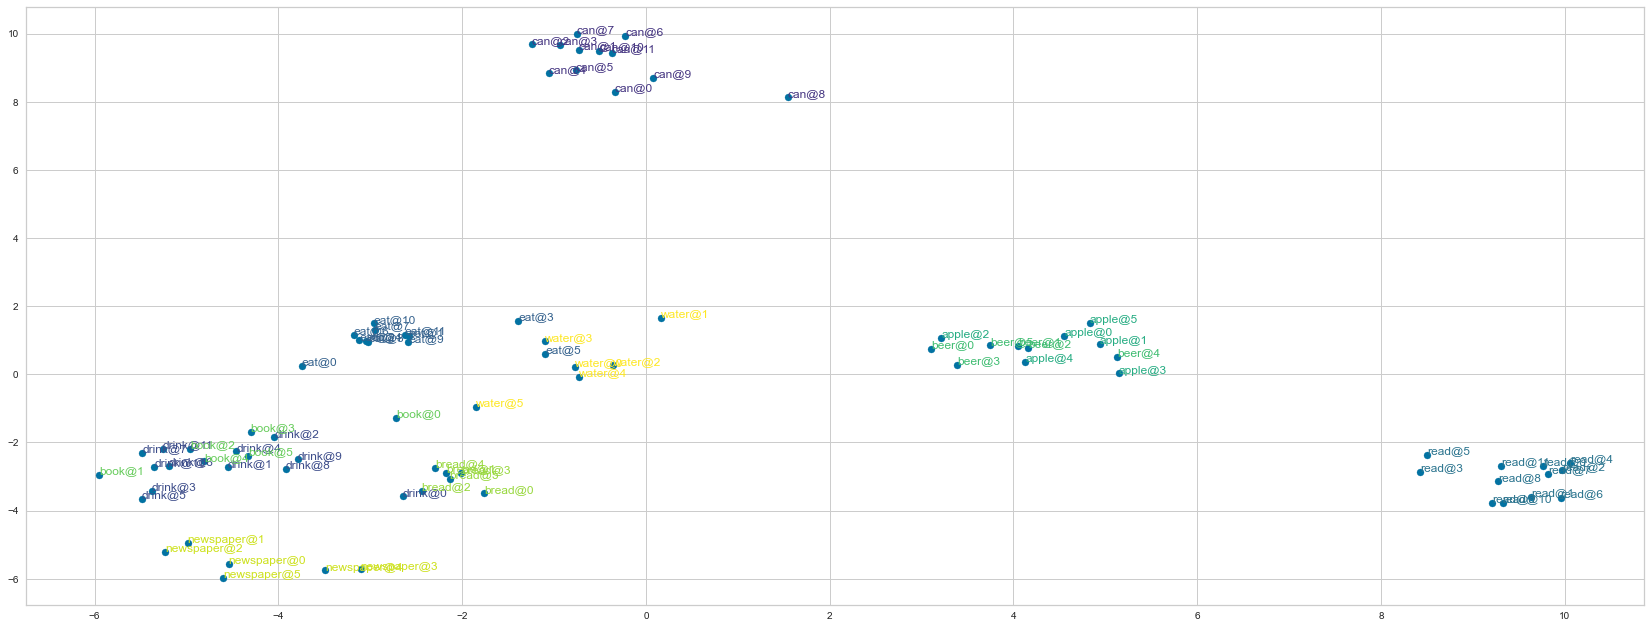

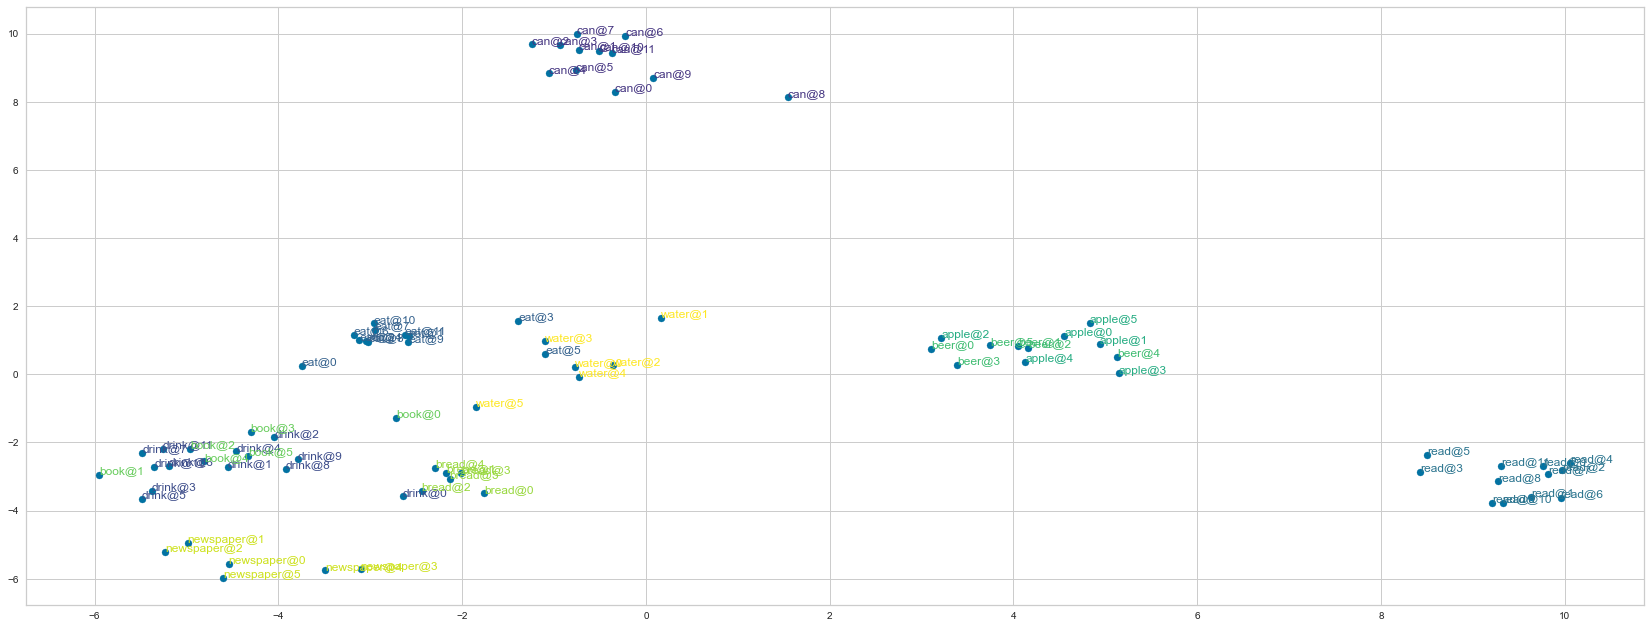

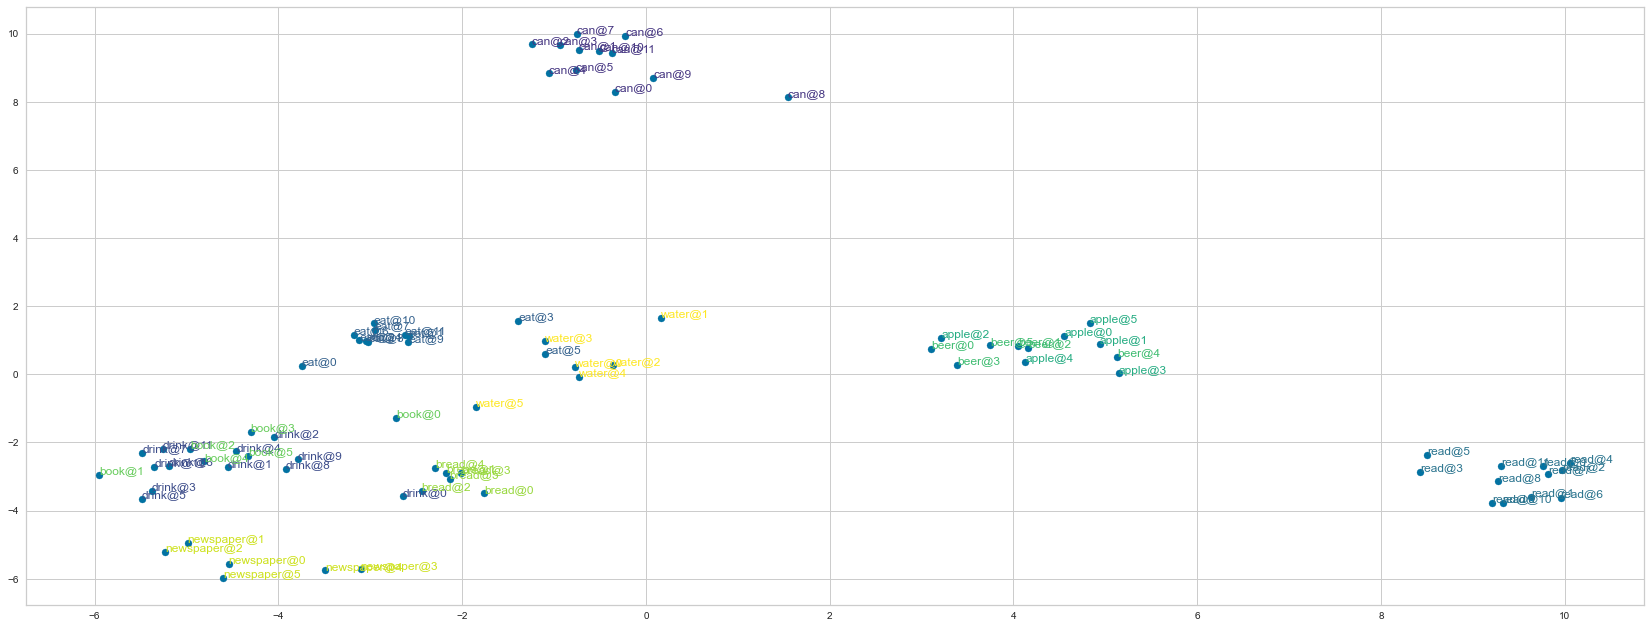

In [47]:
Xs = []
Ys = []
for key in filtered_attention_map.keys():
    print(key)
    key_rows = filtered_attention_map[key]
    sample_attention_values = [ row  for index,row in enumerate(key_rows) if (index+1) % 20 == 0]
    Xs.extend( sample_attention_values )
    Ys.extend( [ key+"@"+str(index) for index in range(len(sample_attention_values))])
    
for i in range(3):
    XQs = [row[i+1] for row in Xs ]
    YQs = [row for row in Ys ]    

    pca = PCA(n_components=2)
    result = pca.fit_transform(np.array(XQs))

    map_on_2d(result,YQs,use_word_colors=True,fig_size=[29,11])

In [48]:
print( data_pipeline[2][1][0].shape)
print( data_pipeline[2][1][1].shape)
print( data_pipeline[2][1][2].shape)
print( data_pipeline[2][1][3].shape)
print( data_pipeline[2][1][3])

torch.Size([8, 1, 5, 64])
torch.Size([8, 1, 5, 64])
torch.Size([8, 1, 5, 64])
torch.Size([8, 1, 5, 5])
tensor([[[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]],


        [[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]],


        [[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, False],
          [ True,  True,  True,  True,  True]]],


        [[[ True, False, False, False, False],
          [ True,  True, False, False, False],
          [ True,  True,  True, False, False],
          [ True,  True,  True,  True, 

In [49]:
add_new_logger("test_loss")

In [50]:
test_loss = evaluate(model, test_iterator, criterion,is_appy_attention=True)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 0.242 | Test PPL:   1.274 |


In [51]:
def translate_sentence(sentence, src_field, trg_field, model, device,is_appy_attention, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask,is_appy_attention)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    ### hold output of linear layer at everytime step
    all_outputs = []
    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask,is_appy_attention)
        
        # #print("trg_mask",trg_mask)
        #print("src_mask",src_mask)
        #print("output.argmax(2)->",output.argmax(2))
        #print("output->",output.shape)
        #print("attention->",attention.shape)
        all_outputs.append(output[:, -1:, :].numpy().flatten())
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention,all_outputs

In [52]:
def display_attention(sentence, translation, attention, n_heads = get_head_count(), n_rows = get_row_count(), n_cols = get_col_count()):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()
    
def encoding_to_sentence(encodings,language):
    return [language.vocab.itos[i] for i in encodings ]    

In [53]:
current_logger.get_default_summary(show_data=False)

summary_count 1    self.capacity  20
Encoder@src_source
[8, 5]
Encoder@src
[8, 5]
Encoder@pos
[8, 5]
encoder@Q
[8, 1, 5, 64]
encoder@K
[8, 1, 5, 64]
encoder@V
[8, 1, 5, 64]
encoder@energy
[8, 1, 5, 5]
encoder@mask
[8, 1, 1, 5]
encoder@attention
[8, 1, 5, 5]
encoder@x1
[8, 1, 5, 64]
encoder@x2
[8, 5, 1, 64]
encoder@x3
[8, 5, 64]
encoder@x4
[8, 5, 64]
PositionwiseFeedforwardLayer@x1
[8, 5, 128]
PositionwiseFeedforwardLayer@x2
[8, 5, 64]
EncoderLayer@_src
[8, 5, 64]
EncoderLayer@src2
[8, 5, 64]
EncoderLayer@_src2
[8, 5, 64]
EncoderLayer@src3
[8, 5, 64]
EncoderLayer@src_mask
[8, 1, 1, 5]
EncoderLayer@sattention
[8, 1, 5, 5]
Encoder@src_final
[8, 5, 64]
decoder_self@Q
[8, 1, 4, 64]
decoder_self@K
[8, 1, 4, 64]
decoder_self@V
[8, 1, 4, 64]
decoder_self@energy
[8, 1, 4, 4]
decoder_self@mask
[8, 1, 4, 4]
decoder_self@attention
[8, 1, 4, 4]
decoder_self@x1
[8, 1, 4, 64]
decoder_self@x2
[8, 4, 1, 64]
decoder_self@x3
[8, 4, 64]
decoder_self@x4
[8, 4, 64]
decoder_encoder_attention@Q
[8, 1, 4, 64]


In [54]:
valid_sentences = []
for i in range(len(tabular_set)):
    valid_sentences.append(" ".join( tabular_set[i].src) )
    
valid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs = test_sentence(tabular_set[i].src,draw_charts=False)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)
    valid_sentences_embeddings.append(trg4[0].numpy().flatten())

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['ich', 'mochten', 'bier', 'trinken', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'read', 'book']
predicted trg = ['ich', 'mochten', 'buch', 'lesen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'mochten', 'zeitung', '<eos>']
summary_count 1    self.capacity  20
Decode

In [55]:
invalid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs = test_sentence(tabular_set[i].src,draw_charts=False,is_appy_attention=False)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["DecoderLayer@trg4"],show_data=False)

    invalid_sentences_embeddings.append(trg4[0].numpy().flatten())

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['wir', 'essen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['wir', 'essen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['wir', 'mochten', 'wasser', 'trinken', 'bier', 'trinken', 'bier', 'trinken', 'bier', 'trinken', 'bier', 'trinken', 'bier', 'trinken', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['wir', 'mochten', 'buch', 'lesen', '<eos>']
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
src = ['i', 'want', 'to', 'read', 'book']
predicted trg = ['ich', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeitung', 'lesen', 'zeit

In [56]:
invalid_sentences_embeddings[0].shape

(64,)

src = ['i', 'can', 'eat', 'bread']
predicted trg = ['ich', 'konnen', 'brot', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,zeitung,brot,buch,wasser
1)ich,-1.558147,-1.818031,0.469576,-1.281489,6.719999,-0.242004,-0.403532,-2.793226,0.324842,-2.279751,-1.725098,1.063727,-0.957881,-0.490431,0.529261,0.898678,0.159587
2)konnen,-1.398428,-0.407349,-0.268237,-1.811347,-2.736078,-0.931341,-0.060913,6.674943,0.817755,-0.288068,0.844611,0.035781,-1.156276,-0.734290,-0.881598,-0.662924,-2.543394
3)brot,-1.724295,-2.306213,-1.227466,-0.948470,-0.350422,-0.112355,1.064940,-1.245919,-2.036485,-3.692834,-2.094623,2.681267,0.573605,-0.551945,3.521476,0.747711,-1.116049
4)essen,-1.881165,-0.752826,-2.614442,-1.555469,-1.737877,-0.851102,6.323942,-0.449784,-1.365053,-1.013193,1.033045,-1.495656,-1.345357,-1.641464,1.125603,-0.244237,-3.581887
5)EOS,0.205182,-2.902647,-2.293833,5.439605,-1.113554,-0.662337,-0.030126,-2.594379,-0.564269,-3.233954,-0.519048,3.788442,0.999583,1.533945,0.477723,-0.137695,-1.183346


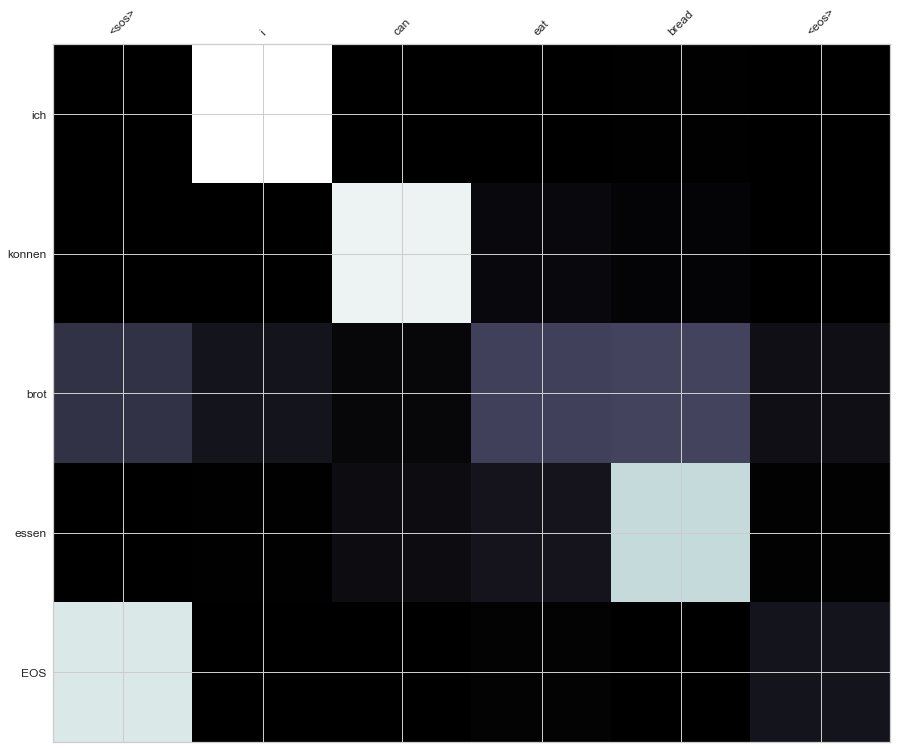

(<__main__.StepLogger at 0x28bf1271088>,
 [array([-1.5581472 , -1.818031  ,  0.46957588, -1.2814885 ,  6.7199993 ,
         -0.24200438, -0.40353197, -2.793226  ,  0.32484165, -2.279751  ,
         -1.7250977 ,  1.063727  , -0.95788085, -0.49043065,  0.5292611 ,
          0.8986775 ,  0.15958658], dtype=float32),
  array([-1.3984277 , -0.4073491 , -0.26823723, -1.8113472 , -2.7360783 ,
         -0.9313412 , -0.06091321,  6.674943  ,  0.8177546 , -0.288068  ,
          0.8446105 ,  0.03578069, -1.1562755 , -0.73429036, -0.88159823,
         -0.6629239 , -2.5433939 ], dtype=float32),
  array([-1.7242945 , -2.3062127 , -1.2274656 , -0.9484698 , -0.35042185,
         -0.11235516,  1.0649405 , -1.2459186 , -2.0364847 , -3.692834  ,
         -2.0946233 ,  2.6812665 ,  0.5736054 , -0.5519453 ,  3.5214756 ,
          0.7477109 , -1.1160492 ], dtype=float32),
  array([-1.8811654 , -0.75282556, -2.6144416 , -1.5554688 , -1.7378765 ,
         -0.85110193,  6.3239417 , -0.44978446, -1.3650532 , -1

In [57]:
test_sentence("i can eat bread",is_appy_attention=True,draw_charts=True)

src = ['i', 'can', 'eat', 'bread']
predicted trg = ['apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', 'apfel', 'essen', '<eos>']


,unk,pad,sos,eos,ich,wir,essen,konnen,lesen,mochten,trinken,apfel,bier,zeitung,brot,buch,wasser
1)apfel,-2.471951,-1.772948,-0.335980,-1.563633,2.709784,1.976439,-0.543689,0.166353,-0.769871,-3.644095,-2.565114,2.843657,-1.727941,-0.656769,1.545377,-0.277497,-1.829410
2)essen,-1.312642,-2.133811,-0.843726,1.192358,-0.262301,-1.479970,5.301594,-0.940381,-0.762509,-4.042835,0.346115,0.189737,-0.121589,-2.015464,1.558673,-0.490604,-1.546726
3)apfel,-1.044348,-2.353024,-1.821109,2.565941,-1.234507,-0.672863,1.192175,-0.936858,-1.045677,-3.608042,-0.395239,3.352021,0.655802,-0.331694,2.725625,0.470874,-2.012209
4)essen,-1.634057,-2.908442,-0.375577,1.965086,0.084778,-1.053298,3.742587,-1.127762,-0.471678,-4.467377,-0.603720,1.252377,-0.230460,-1.540278,1.701651,-0.282573,-1.256426
5)apfel,-1.008634,-2.376304,-1.879658,3.189792,-1.152258,-0.833435,1.304509,-0.976916,-0.931376,-3.661844,-0.267240,3.347640,0.873004,-0.121936,2.447314,0.341882,-2.058951
6)essen,-1.664108,-2.854641,-0.455001,2.420324,-0.073608,-1.066658,3.642071,-1.109046,-0.664260,-4.551412,-0.535524,1.492823,-0.239358,-1.116010,1.468241,-0.587248,-1.450016
7)apfel,-0.988136,-2.344378,-2.108099,3.052692,-1.131630,-0.721091,1.403793,-1.032442,-0.902244,-3.497237,-0.090833,3.366835,0.773229,-0.147261,2.346179,0.213533,-2.251755
8)essen,-1.643936,-2.921688,-0.471815,2.652374,-0.125393,-1.184993,3.480600,-1.123159,-0.517370,-4.608885,-0.456872,1.589597,-0.081653,-1.098246,1.518450,-0.371042,-1.443309
9)apfel,-0.999640,-2.259126,-1.965217,3.112397,-1.179657,-0.725121,1.546439,-0.924296,-1.007104,-3.558519,-0.115892,3.285388,0.827440,-0.181700,2.408554,0.308123,-2.170506
10)essen,-1.652644,-2.837058,-0.525804,2.756651,-0.204844,-1.145852,3.762745,-1.321921,-0.552076,-4.504165,-0.467673,1.515128,0.000347,-1.059371,1.371996,-0.481178,-1.413668


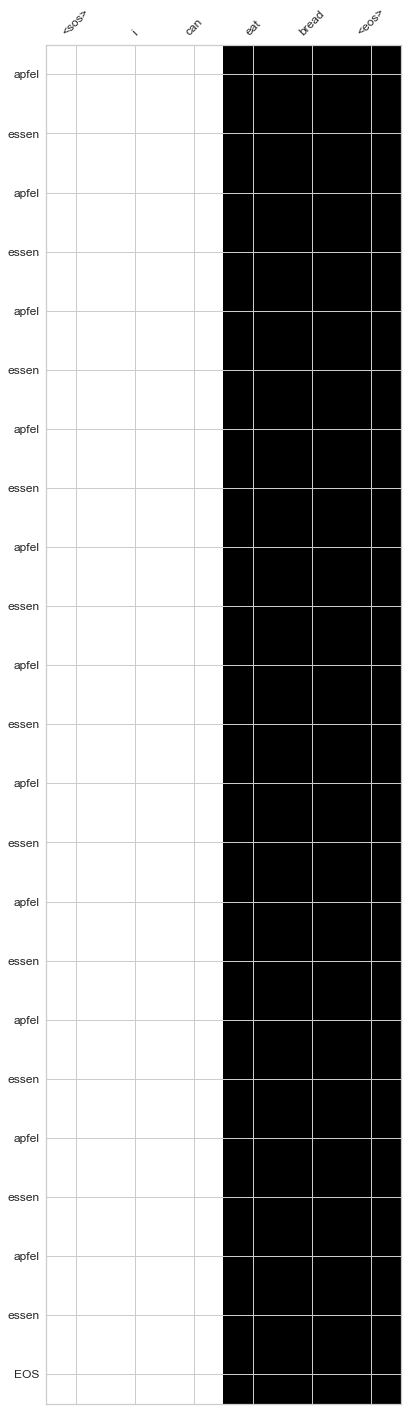

(<__main__.StepLogger at 0x28bf412db48>,
 [array([-2.4719515 , -1.7729481 , -0.33597994, -1.5636328 ,  2.7097836 ,
          1.9764385 , -0.54368895,  0.16635276, -0.7698709 , -3.6440952 ,
         -2.5651143 ,  2.8436575 , -1.7279406 , -0.65676945,  1.5453775 ,
         -0.2774971 , -1.8294102 ], dtype=float32),
  array([-1.3126417 , -2.1338105 , -0.8437264 ,  1.1923581 , -0.2623008 ,
         -1.4799697 ,  5.3015943 , -0.9403811 , -0.76250935, -4.0428348 ,
          0.34611502,  0.18973726, -0.12158916, -2.0154636 ,  1.5586733 ,
         -0.49060357, -1.5467255 ], dtype=float32),
  array([-1.0443478 , -2.353024  , -1.821109  ,  2.5659409 , -1.2345073 ,
         -0.67286307,  1.1921754 , -0.9368575 , -1.0456772 , -3.6080422 ,
         -0.39523926,  3.3520205 ,  0.65580153, -0.33169422,  2.7256248 ,
          0.47087377, -2.0122092 ], dtype=float32),
  array([-1.634057  , -2.908442  , -0.37557662,  1.9650865 ,  0.08477813,
         -1.0532985 ,  3.7425873 , -1.1277616 , -0.4716775 , -4

In [58]:
test_sentence("i can eat bread",is_appy_attention=False,draw_charts=True)

In [59]:
Xs = []
Ys = []
for index,sentence in enumerate(valid_sentences):
    logger,all_outputs = test_sentence(sentence,draw_charts=False,is_appy_attention=True)
    labels = logger.get_summary(labels=["Encoder@src_source"],show_data=False)
    datas = logger.get_summary(labels=["Encoder@src_final"],show_data=False)
    words = encoding_to_sentence(labels[0].numpy().flatten(),SRC)
    for index_word,data in enumerate(datas[0].squeeze() ):
        print(data.shape)
        if words[index_word] != "<eos>" and words[index_word] != "<sos>":
            Xs.append( data.numpy() )
            Ys.append( words[index_word]+"@"+str(index) )

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 7]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 7, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 7]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 7, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 7]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 7, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Si

summary_count 1    self.capacity  20
Encoder@src_source
[1, 5]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 5, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
src = ['i', 'drink', 'water']
predicted trg = ['ich', 'trinken', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 5]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 5, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
src = ['i', 'drink', 'beer']
predicted trg = ['ich', 'trinken', 'bier', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 5]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 5, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
src = ['i', 'read', 'book']
predicted trg = ['ich', 'lesen', 'zeitung', '<eos>']
summary_count 1    self.capacity  20
Encoder@src_source
[1, 5]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 

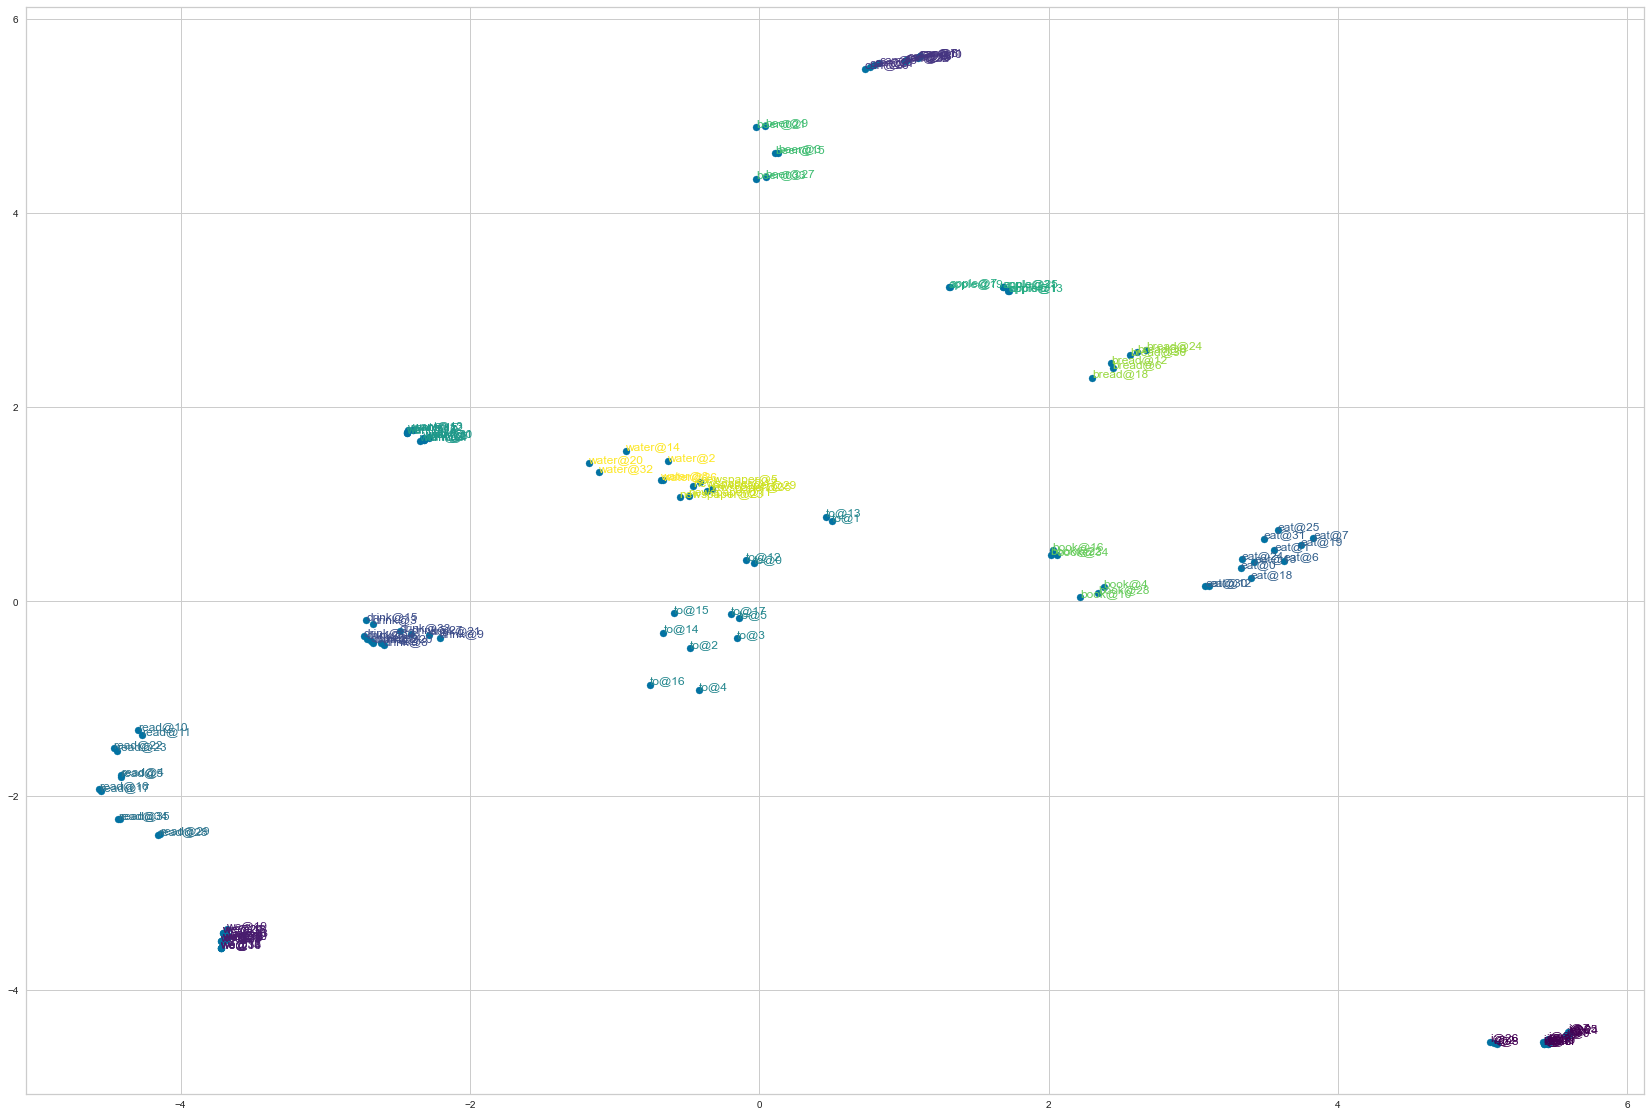

In [60]:
pca = PCA(n_components=2)
result = pca.fit_transform(np.array(Xs))

map_on_2d(result,Ys,use_word_colors=True,fig_size=[29,20])

summary_count 1    self.capacity  20
Encoder@src_source
[1, 5]
summary_count 1    self.capacity  20
Encoder@src_final
[1, 5, 64]
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])
torch.Size([64])


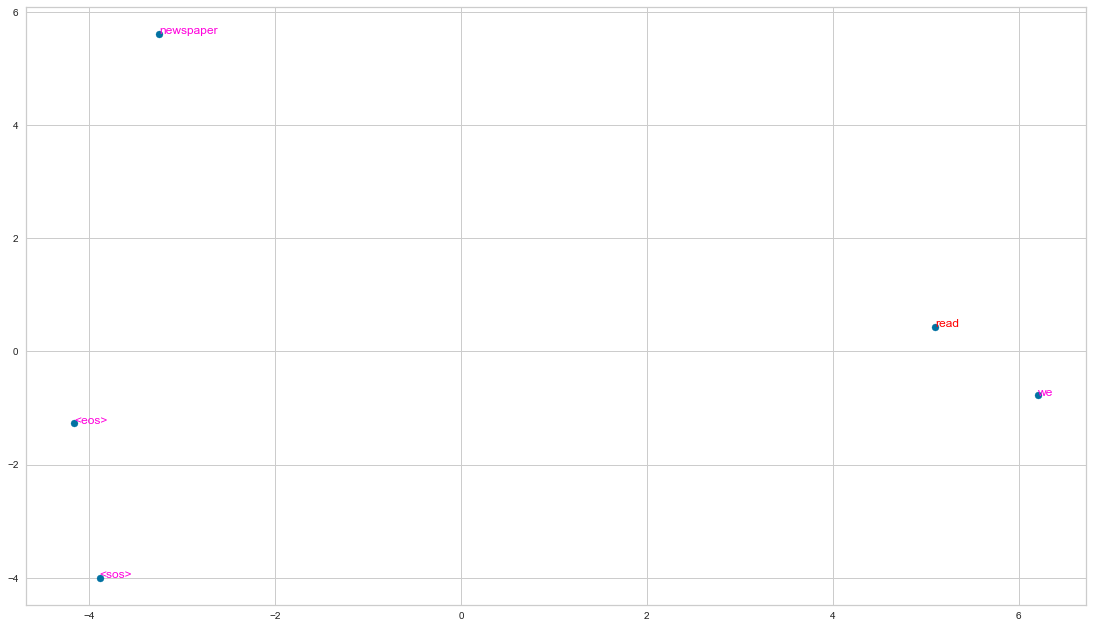

In [61]:

labels = logger.get_summary(labels=["Encoder@src_source"],show_data=False)
datas = logger.get_summary(labels=["Encoder@src_final"],show_data=False)
words = encoding_to_sentence(labels[0].numpy().flatten(),SRC)
#TRG.vocab.itos
#[SRC.vocab.itos[i] for i in datas[0].numpy().flatten() ]
Xs = []

for data in datas[0].squeeze():
    print(data.shape)
    Xs.append( data.numpy() )

pca = PCA(n_components=2)
result = pca.fit_transform(np.array(Xs))

map_on_2d(result,words)

In [62]:
logger.get_summary(labels=["Encoder@src_final"],show_data=False)

summary_count 1    self.capacity  20
Encoder@src_final
[1, 5, 64]


[tensor([[[ 0.0355, -0.9650, -0.7616,  1.3154,  0.3080, -0.4569, -0.9900,
            1.4881,  1.2955, -1.8397, -0.7753, -0.1274,  1.6444, -1.2993,
            0.1912,  0.5988, -1.2667, -1.2914, -1.5527, -1.3441, -0.2122,
            0.5997,  1.0683,  1.3891,  1.1140, -0.0460,  1.2815,  0.5646,
           -1.0685,  1.3372,  0.1650, -1.9964,  0.8927,  0.6844, -0.7745,
            0.3878,  0.0465, -0.2847, -0.5073, -0.8519, -1.3741,  1.0231,
           -0.2622,  1.1185,  0.6506,  1.3293,  1.3043, -1.9346, -0.2968,
           -0.3834, -0.9146,  1.0120,  0.8134,  0.3846,  1.1171, -1.2154,
           -0.4717,  0.6611, -0.0691, -0.5901,  0.2343, -1.7409,  0.4321,
            1.1189],
          [-0.4409,  2.0042,  0.4887,  0.9017, -1.3727,  0.5031, -0.0213,
            0.6342,  1.7309,  0.5191,  1.2136,  1.1987,  0.3062, -1.0612,
            0.5040,  0.0151,  0.6151, -0.5682, -0.3774,  1.3196,  0.8746,
           -0.3008,  1.4176, -1.0140, -1.1166,  0.8027, -0.4685, -1.0016,
            0.806

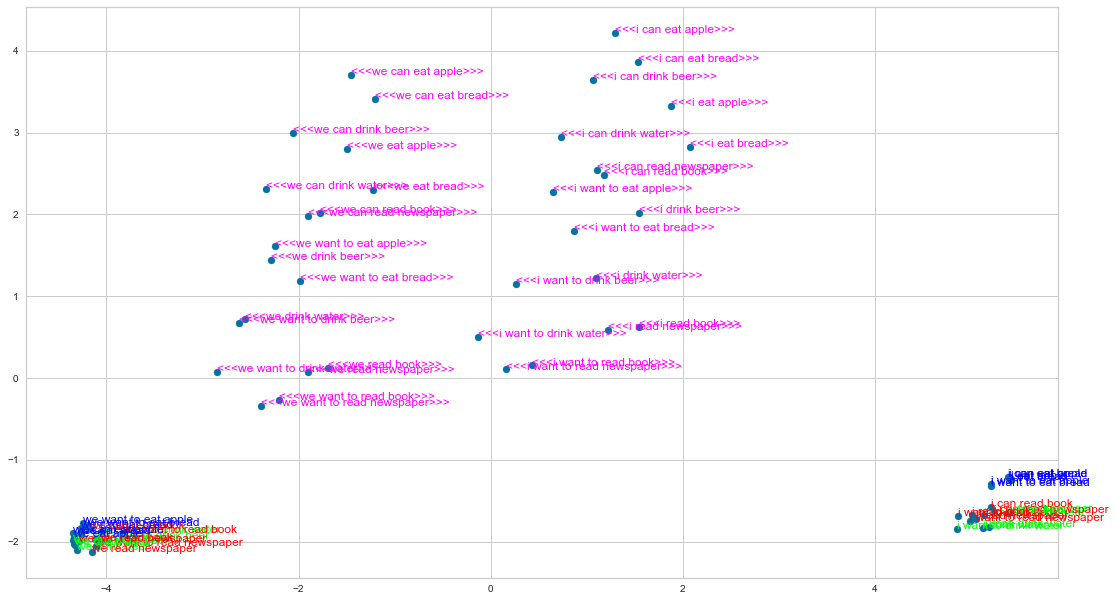

In [63]:
show_on_vis_multi(invalid_sentences_embeddings,valid_sentences,valid_sentences_embeddings,valid_sentences)

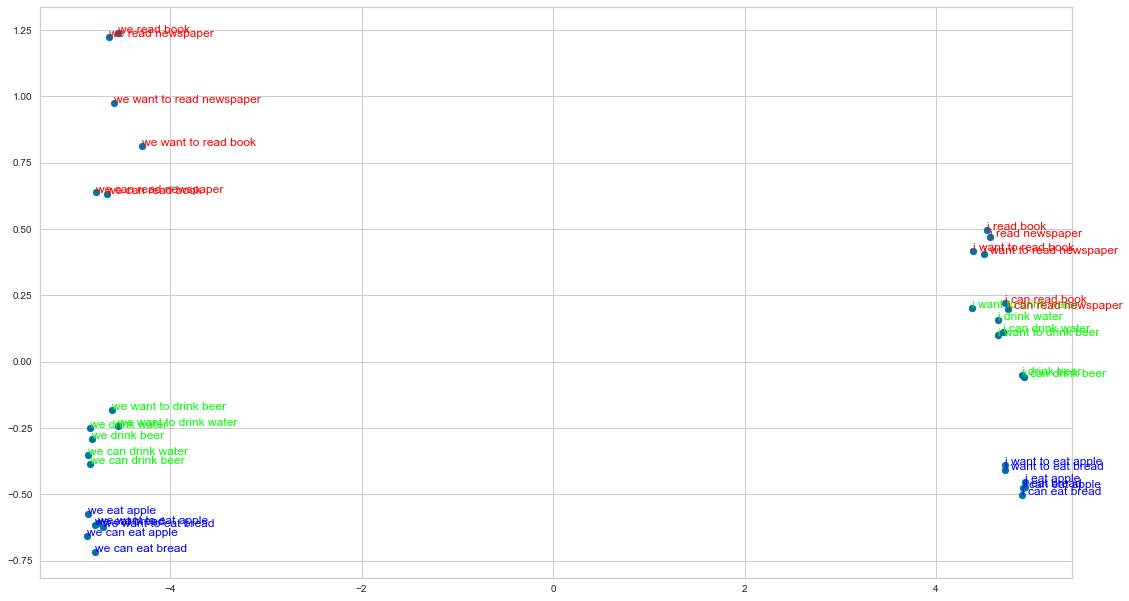

In [64]:
show_on_vis_multi([],[],valid_sentences_embeddings,valid_sentences)

In [65]:
logger,all_outputs = test_sentence("we drink water",is_appy_attention=False,draw_charts=False)


src = ['we', 'drink', 'water']
predicted trg = ['wir', 'trinken', 'bier', 'trinken', 'bier', 'trinken', '<eos>']


In [66]:
test_logger,all_outputs = test_sentence(tabular_set[0].src,draw_charts=False,is_appy_attention=True)
print(tabular_set[0])
trg4 = test_logger.get_summary(labels=["EncoderLayer@src3"],show_data=False)
trg4[0].shape

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]


torch.Size([1, 7, 64])

In [67]:
valid_sentences_embeddings = []
for i in range(len(tabular_set)):
    test_logger,all_outputs = test_sentence(tabular_set[i].src,draw_charts=False,is_appy_attention=True)
    #train_data.examples[example_idx].src
    #test_logger.get_default_summary()
    trg4 = test_logger.get_summary(labels=["EncoderLayer@src3"],show_data=False)
    valid_sentences_embeddings.append(trg4[0].squeeze().numpy())

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]
src = ['i', 'want', 'to', 'eat', 'apple']
predicted trg = ['ich', 'mochten', 'apfel', 'essen', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]
src = ['i', 'want', 'to', 'drink', 'water']
predicted trg = ['ich', 'mochten', 'wasser', 'trinken', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]
src = ['i', 'want', 'to', 'drink', 'beer']
predicted trg = ['ich', 'mochten', 'bier', 'trinken', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]
src = ['i', 'want', 'to', 'read', 'book']
predicted trg = ['ich', 'mochten', 'buch', 'lesen', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@src3
[1, 7, 64]
src = ['i', 'want', 'to', 'read', 'newspaper']
predicted trg = ['ich', 'mochten', 'zeitung', '<eos>']
summary_count 1    self.capacity  20
Encode

In [68]:
#valid_sentences_embeddings_flat = []
#for embeddings in valid_sentences_embeddings:
#print(valid_sentences_embeddings[0] )
#np.mean(valid_sentences_embeddings[0],axis=0)    

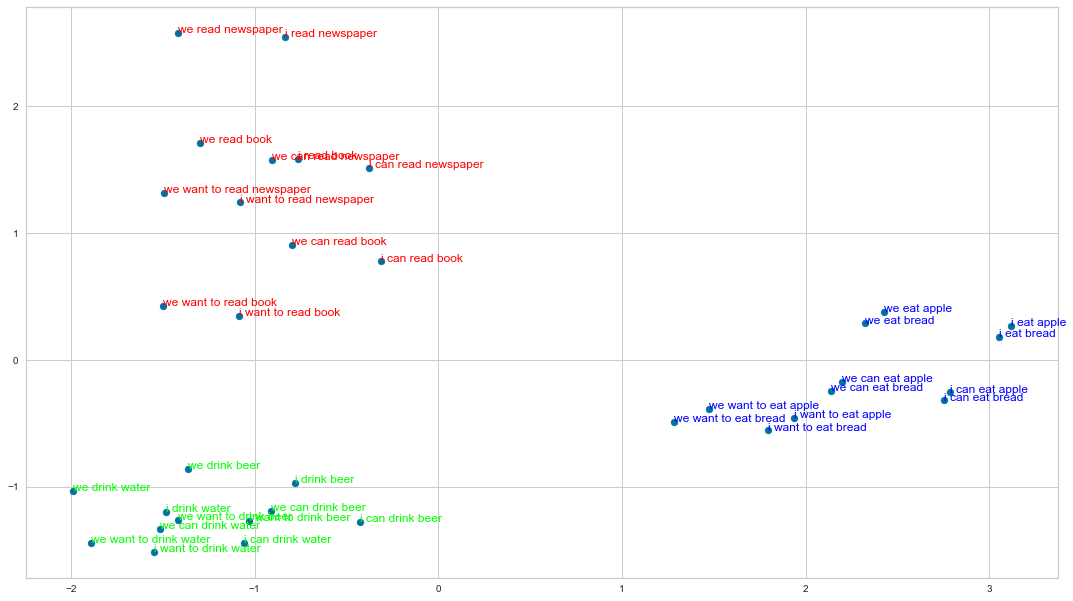

(7, 64)


(36,)

In [69]:
###NP MEAN IS NOT SO GOOD
##FIND ANOTHER WAY
#(7, 64) , (5, 64) all elements have different shape
#here sentence has embedding so must get a summary of these
valid_sentences_embedding_means = []
for embedding in valid_sentences_embeddings:
    #print("embedding",embedding.shape[0])
    valid_sentences_embedding_means.append( np.mean(embedding,axis=0)    )
show_on_vis_multi([],[],valid_sentences_embedding_means,valid_sentences)
print(valid_sentences_embeddings[0].shape)
np.array(valid_sentences_embeddings).shape

src = ['i', 'can', 'drink', 'water']
trg = ['ich', 'konnen', 'wasser', 'trinken']
predicted trg = ['ich', 'konnen', 'wasser', 'trinken', '<eos>']


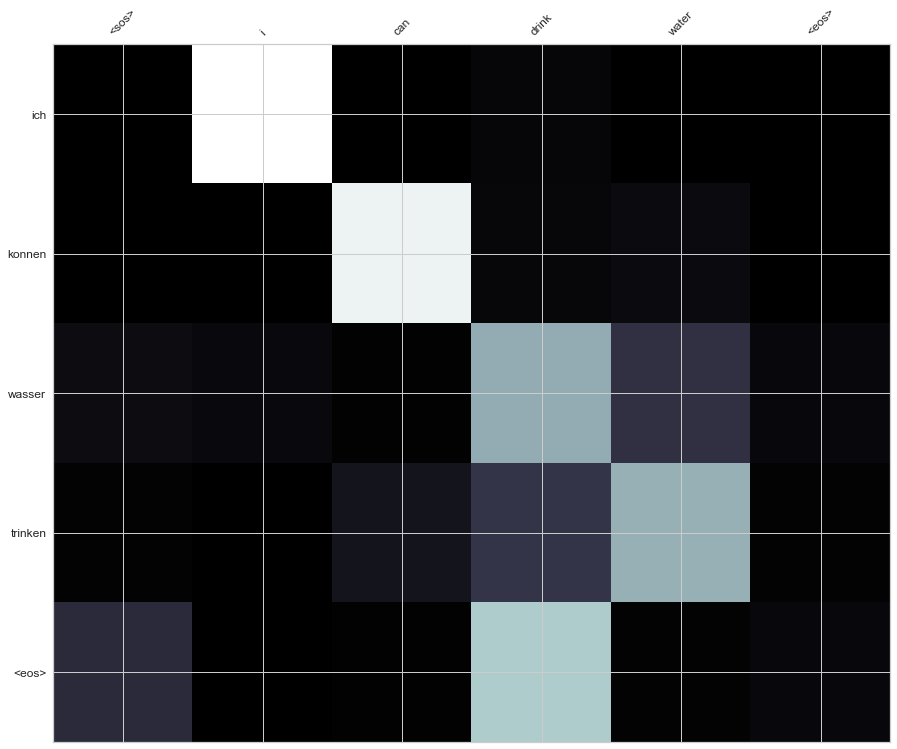

In [70]:
add_new_logger("sample1")
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

currentLogger = StepLogger(100)  
translation, attention, all_outputs = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=True)

print(f'predicted trg = {translation}')
 
display_attention(src, translation, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())

In [71]:
def draw_df(data,columns,indexes):
    df2 = pd.DataFrame(data,columns=columns,index=indexes)
    cm = sns.light_palette("blue", as_cmap=True)
    styled_df = df2.style.background_gradient(cmap=cm)
    display(styled_df)

In [72]:
#test_logger.get_default_summary(show_data=True)
for index in range(1):
    
    test_logger,all_outputs = test_sentence(tabular_set[index].src,draw_charts=False,is_appy_attention=True)
    encoded_attention = test_logger.get_summary(["EncoderLayer@sattention"],show_data=False)
    
    src_masks = test_logger.get_summary(["EncoderLayer@src_mask"],show_data=False,summary_count=10)
    print("EncoderLayersrc_masks",src_masks)
    
    decodersrc_masks = test_logger.get_summary(["DecoderLayer@src_mask"],show_data=False,summary_count=10)
    print("decodersrc_masks",decodersrc_masks)
    
    
    decoder_attention = test_logger.get_summary(["Decoder@attention"],show_data=False,summary_count=10)
    print("decoder_attention",decoder_attention[0].shape)
    print("decoder_attention",decoder_attention[0])
    
    decodertrg_masks = test_logger.get_summary(["DecoderLayer@trg_mask"],show_data=False,summary_count=10)
    for index2,dm in enumerate(decodertrg_masks):
        print("decodertrg_masks",index2)
        print(dm)
    
    output_words = ["sos"]+tabular_set[index].src  +["eos"]
    for head_index in range(encoded_attention[0].shape[1]):
        all_outputs0 = encoded_attention[0][:,head_index,:,:]
        draw_df(all_outputs0.squeeze().numpy(),output_words,output_words)
    
    ### OPEN THIS COMMENT FOR MULTI HEAD all_outputs1 = encoded_attention[0][:,1,:,:]
    ###draw_df(all_outputs1.squeeze().numpy(),output_words,output_words)
#df2 = pd.DataFrame(all_outputs.squeeze().numpy(),columns=output_words,index=output_words)
#cm = sns.light_palette("blue", as_cmap=True)

#styled_df = df2.style.background_gradient(cmap=cm)
#styled_df

src = ['i', 'want', 'to', 'eat', 'bread']
predicted trg = ['ich', 'mochten', 'brot', 'essen', '<eos>']
summary_count 1    self.capacity  20
EncoderLayer@sattention
[1, 1, 7, 7]
summary_count 10    self.capacity  20
EncoderLayer@src_mask
[1, 1, 1, 7]
EncoderLayersrc_masks [tensor([[[[True, True, True, True, True, True, True]]]])]
summary_count 10    self.capacity  20
DecoderLayer@src_mask
[1, 1, 1, 7]
DecoderLayer@src_mask
[1, 1, 1, 7]
DecoderLayer@src_mask
[1, 1, 1, 7]
DecoderLayer@src_mask
[1, 1, 1, 7]
DecoderLayer@src_mask
[1, 1, 1, 7]
decodersrc_masks [tensor([[[[True, True, True, True, True, True, True]]]]), tensor([[[[True, True, True, True, True, True, True]]]]), tensor([[[[True, True, True, True, True, True, True]]]]), tensor([[[[True, True, True, True, True, True, True]]]]), tensor([[[[True, True, True, True, True, True, True]]]])]
summary_count 10    self.capacity  20
Decoder@attention
[1, 1, 1, 7]
Decoder@attention
[1, 1, 2, 7]
Decoder@attention
[1, 1, 3, 7]
Decoder@attention

,sos,i,want,to,eat,bread,eos
sos,0.018482,0.072242,0.379664,0.058229,0.034594,0.414351,0.022438
i,0.212376,0.398929,0.019641,0.070928,0.257033,0.032505,0.008588
want,0.035945,0.175452,0.108845,0.640532,0.028732,0.003701,0.006794
to,0.051731,0.063483,0.022577,0.006823,0.625850,0.218059,0.011477
eat,0.292414,0.023915,0.057862,0.221833,0.113833,0.220740,0.069402
bread,0.136652,0.026146,0.010470,0.033206,0.010706,0.356982,0.425837
eos,0.046441,0.005325,0.023380,0.044782,0.004120,0.844337,0.031615


In [73]:
loggers.keys()

dict_keys(['training', 'test_loss', 'iwanttoeatbread115536', 'iwanttoeatapple30632', 'iwanttodrinkwater1964', 'iwanttodrinkbeer23762', 'iwanttoreadbook152628', 'iwanttoreadnewspaper9156', 'icaneatbread176047', 'icaneatapple22004', 'icandrinkwater25801', 'icandrinkbeer92966', 'icanreadbook62079', 'icanreadnewspaper4569', 'wewanttoeatbread8078', 'wewanttoeatapple4153', 'wewanttodrinkwater90726', 'wewanttodrinkbeer169953', 'wewanttoreadbook163390', 'wewanttoreadnewspaper126943', 'wecaneatbread161433', 'wecaneatapple121517', 'wecandrinkwater38943', 'wecandrinkbeer23931', 'wecanreadbook47997', 'wecanreadnewspaper29993', 'ieatbread3833', 'ieatapple131881', 'idrinkwater127599', 'idrinkbeer65491', 'ireadbook16925', 'ireadnewspaper174918', 'weeatbread141844', 'weeatapple122133', 'wedrinkwater17976', 'wedrinkbeer157671', 'wereadbook176981', 'wereadnewspaper23313', 'iwanttoeatbread135016', 'iwanttoeatapple151783', 'iwanttodrinkwater12050', 'iwanttodrinkbeer70671', 'iwanttoreadbook145866', 'iwantt

In [74]:
loggers["training"].get_default_summary()


summary_count 1    self.capacity  20
Encoder@src_source
[8, 7]
Encoder@src
[8, 7]
Encoder@pos
[8, 7]
encoder@Q
[8, 1, 7, 64]
encoder@K
[8, 1, 7, 64]
encoder@V
[8, 1, 7, 64]
encoder@energy
[8, 1, 7, 7]
encoder@mask
[8, 1, 1, 7]
encoder@attention
[8, 1, 7, 7]
encoder@x1
[8, 1, 7, 64]
encoder@x2
[8, 7, 1, 64]
encoder@x3
[8, 7, 64]
encoder@x4
[8, 7, 64]
PositionwiseFeedforwardLayer@x1
[8, 7, 128]
PositionwiseFeedforwardLayer@x2
[8, 7, 64]
EncoderLayer@_src
[8, 7, 64]
EncoderLayer@src2
[8, 7, 64]
EncoderLayer@_src2
[8, 7, 64]
EncoderLayer@src3
[8, 7, 64]
EncoderLayer@src_mask
[8, 1, 1, 7]
EncoderLayer@sattention
[8, 1, 7, 7]
Encoder@src_final
[8, 7, 64]
decoder_self@Q
[8, 1, 5, 64]
decoder_self@K
[8, 1, 5, 64]
decoder_self@V
[8, 1, 5, 64]
decoder_self@energy
[8, 1, 5, 5]
decoder_self@mask
[8, 1, 5, 5]
decoder_self@attention
[8, 1, 5, 5]
decoder_self@x1
[8, 1, 5, 64]
decoder_self@x2
[8, 5, 1, 64]
decoder_self@x3
[8, 5, 64]
decoder_self@x4
[8, 5, 64]
decoder_encoder_attention@Q
[8, 1, 5, 64]


In [75]:
loggers["test_loss"].get_default_summary()


summary_count 1    self.capacity  20
Encoder@src_source
[8, 5]
Encoder@src
[8, 5]
Encoder@pos
[8, 5]
encoder@Q
[8, 1, 5, 64]
encoder@K
[8, 1, 5, 64]
encoder@V
[8, 1, 5, 64]
encoder@energy
[8, 1, 5, 5]
encoder@mask
[8, 1, 1, 5]
encoder@attention
[8, 1, 5, 5]
encoder@x1
[8, 1, 5, 64]
encoder@x2
[8, 5, 1, 64]
encoder@x3
[8, 5, 64]
encoder@x4
[8, 5, 64]
PositionwiseFeedforwardLayer@x1
[8, 5, 128]
PositionwiseFeedforwardLayer@x2
[8, 5, 64]
EncoderLayer@_src
[8, 5, 64]
EncoderLayer@src2
[8, 5, 64]
EncoderLayer@_src2
[8, 5, 64]
EncoderLayer@src3
[8, 5, 64]
EncoderLayer@src_mask
[8, 1, 1, 5]
EncoderLayer@sattention
[8, 1, 5, 5]
Encoder@src_final
[8, 5, 64]
decoder_self@Q
[8, 1, 4, 64]
decoder_self@K
[8, 1, 4, 64]
decoder_self@V
[8, 1, 4, 64]
decoder_self@energy
[8, 1, 4, 4]
decoder_self@mask
[8, 1, 4, 4]
decoder_self@attention
[8, 1, 4, 4]
decoder_self@x1
[8, 1, 4, 64]
decoder_self@x2
[8, 4, 1, 64]
decoder_self@x3
[8, 4, 64]
decoder_self@x4
[8, 4, 64]
decoder_encoder_attention@Q
[8, 1, 4, 64]


In [76]:
loggers["sample1"].get_default_summary()


summary_count 1    self.capacity  20
Encoder@src_source
[1, 6]
Encoder@src
[1, 6]
Encoder@pos
[1, 6]
encoder@Q
[1, 1, 6, 64]
encoder@K
[1, 1, 6, 64]
encoder@V
[1, 1, 6, 64]
encoder@energy
[1, 1, 6, 6]
encoder@mask
[1, 1, 1, 6]
encoder@attention
[1, 1, 6, 6]
encoder@x1
[1, 1, 6, 64]
encoder@x2
[1, 6, 1, 64]
encoder@x3
[1, 6, 64]
encoder@x4
[1, 6, 64]
PositionwiseFeedforwardLayer@x1
[1, 6, 128]
PositionwiseFeedforwardLayer@x2
[1, 6, 64]
EncoderLayer@_src
[1, 6, 64]
EncoderLayer@src2
[1, 6, 64]
EncoderLayer@_src2
[1, 6, 64]
EncoderLayer@src3
[1, 6, 64]
EncoderLayer@src_mask
[1, 1, 1, 6]
EncoderLayer@sattention
[1, 1, 6, 6]
Encoder@src_final
[1, 6, 64]
decoder_self@Q
[1, 1, 1, 64]
decoder_self@K
[1, 1, 1, 64]
decoder_self@V
[1, 1, 1, 64]
decoder_self@energy
[1, 1, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 1, 1, 1]
decoder_self@x1
[1, 1, 1, 64]
decoder_self@x2
[1, 1, 1, 64]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_attention@Q
[1, 1, 1, 64]


In [77]:
current_logger.get_default_summary(show_data=False)

summary_count 1    self.capacity  20
Encoder@src_source
[1, 7]
Encoder@src
[1, 7]
Encoder@pos
[1, 7]
encoder@Q
[1, 1, 7, 64]
encoder@K
[1, 1, 7, 64]
encoder@V
[1, 1, 7, 64]
encoder@energy
[1, 1, 7, 7]
encoder@mask
[1, 1, 1, 7]
encoder@attention
[1, 1, 7, 7]
encoder@x1
[1, 1, 7, 64]
encoder@x2
[1, 7, 1, 64]
encoder@x3
[1, 7, 64]
encoder@x4
[1, 7, 64]
PositionwiseFeedforwardLayer@x1
[1, 7, 128]
PositionwiseFeedforwardLayer@x2
[1, 7, 64]
EncoderLayer@_src
[1, 7, 64]
EncoderLayer@src2
[1, 7, 64]
EncoderLayer@_src2
[1, 7, 64]
EncoderLayer@src3
[1, 7, 64]
EncoderLayer@src_mask
[1, 1, 1, 7]
EncoderLayer@sattention
[1, 1, 7, 7]
Encoder@src_final
[1, 7, 64]
decoder_self@Q
[1, 1, 1, 64]
decoder_self@K
[1, 1, 1, 64]
decoder_self@V
[1, 1, 1, 64]
decoder_self@energy
[1, 1, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 1, 1, 1]
decoder_self@x1
[1, 1, 1, 64]
decoder_self@x2
[1, 1, 1, 64]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_attention@Q
[1, 1, 1, 64]


In [78]:
#currentLogger.get_default_summary(show_data=False)

In [79]:

#currentLogger.get_summary(labels=["Q"],show_data=True)

In [80]:
loggers.keys()

dict_keys(['training', 'test_loss', 'iwanttoeatbread115536', 'iwanttoeatapple30632', 'iwanttodrinkwater1964', 'iwanttodrinkbeer23762', 'iwanttoreadbook152628', 'iwanttoreadnewspaper9156', 'icaneatbread176047', 'icaneatapple22004', 'icandrinkwater25801', 'icandrinkbeer92966', 'icanreadbook62079', 'icanreadnewspaper4569', 'wewanttoeatbread8078', 'wewanttoeatapple4153', 'wewanttodrinkwater90726', 'wewanttodrinkbeer169953', 'wewanttoreadbook163390', 'wewanttoreadnewspaper126943', 'wecaneatbread161433', 'wecaneatapple121517', 'wecandrinkwater38943', 'wecandrinkbeer23931', 'wecanreadbook47997', 'wecanreadnewspaper29993', 'ieatbread3833', 'ieatapple131881', 'idrinkwater127599', 'idrinkbeer65491', 'ireadbook16925', 'ireadnewspaper174918', 'weeatbread141844', 'weeatapple122133', 'wedrinkwater17976', 'wedrinkbeer157671', 'wereadbook176981', 'wereadnewspaper23313', 'iwanttoeatbread135016', 'iwanttoeatapple151783', 'iwanttodrinkwater12050', 'iwanttodrinkbeer70671', 'iwanttoreadbook145866', 'iwantt

In [81]:
loggers["sample1"].get_default_summary(show_data=False)

summary_count 1    self.capacity  20
Encoder@src_source
[1, 6]
Encoder@src
[1, 6]
Encoder@pos
[1, 6]
encoder@Q
[1, 1, 6, 64]
encoder@K
[1, 1, 6, 64]
encoder@V
[1, 1, 6, 64]
encoder@energy
[1, 1, 6, 6]
encoder@mask
[1, 1, 1, 6]
encoder@attention
[1, 1, 6, 6]
encoder@x1
[1, 1, 6, 64]
encoder@x2
[1, 6, 1, 64]
encoder@x3
[1, 6, 64]
encoder@x4
[1, 6, 64]
PositionwiseFeedforwardLayer@x1
[1, 6, 128]
PositionwiseFeedforwardLayer@x2
[1, 6, 64]
EncoderLayer@_src
[1, 6, 64]
EncoderLayer@src2
[1, 6, 64]
EncoderLayer@_src2
[1, 6, 64]
EncoderLayer@src3
[1, 6, 64]
EncoderLayer@src_mask
[1, 1, 1, 6]
EncoderLayer@sattention
[1, 1, 6, 6]
Encoder@src_final
[1, 6, 64]
decoder_self@Q
[1, 1, 1, 64]
decoder_self@K
[1, 1, 1, 64]
decoder_self@V
[1, 1, 1, 64]
decoder_self@energy
[1, 1, 1, 1]
decoder_self@mask
[1, 1, 1, 1]
decoder_self@attention
[1, 1, 1, 1]
decoder_self@x1
[1, 1, 1, 64]
decoder_self@x2
[1, 1, 1, 64]
decoder_self@x3
[1, 1, 64]
decoder_self@x4
[1, 1, 64]
decoder_encoder_attention@Q
[1, 1, 1, 64]


In [82]:
attention_orig = loggers["sample1"].get_summary(labels=["decoder_encoder_attention@attention"],show_data=True)
trg4 = loggers["sample1"].get_summary(labels=["DecoderLayer@trg4"],show_data=True)

summary_count 1    self.capacity  20
decoder_encoder_attention@attention
[1, 1, 1, 6]
tensor([[[[0.0014, 0.9574, 0.0022, 0.0300, 0.0056, 0.0033]]]])
summary_count 1    self.capacity  20
DecoderLayer@trg4
[1, 1, 64]
tensor([[[ 0.0623,  1.6410, -0.0149,  0.8975,  1.2415, -0.3444,  0.6093,
          -0.7787, -0.6854,  0.9000, -0.4367,  1.7943, -0.4259, -0.4313,
           1.0362,  0.5516,  0.3691, -1.5591,  0.4887,  0.9553, -0.4652,
           1.0574,  0.2480, -0.5142,  0.0040, -1.0989, -0.2635, -1.0267,
           0.2343,  0.6605, -0.5538, -0.2241,  0.2689,  1.0084, -0.2777,
          -2.7517,  0.6556, -1.2126,  0.8014,  0.1327, -0.8015,  1.8973,
           1.0054, -0.6205, -1.5822,  0.5263,  2.8325,  0.8614,  0.4501,
           0.2844, -0.8917,  0.7339, -1.7701, -1.6052, -0.3026,  0.0322,
           1.2759, -0.3990, -1.2216, -0.8817,  0.5828, -0.7979, -0.1205,
          -1.8373]]])


src = ['we', 'can', 'eat', 'bread']
trg = ['wir', 'konnen', 'brot', 'essen']
predicted trg = ['wir', 'essen', 'brot', 'essen', '<eos>']


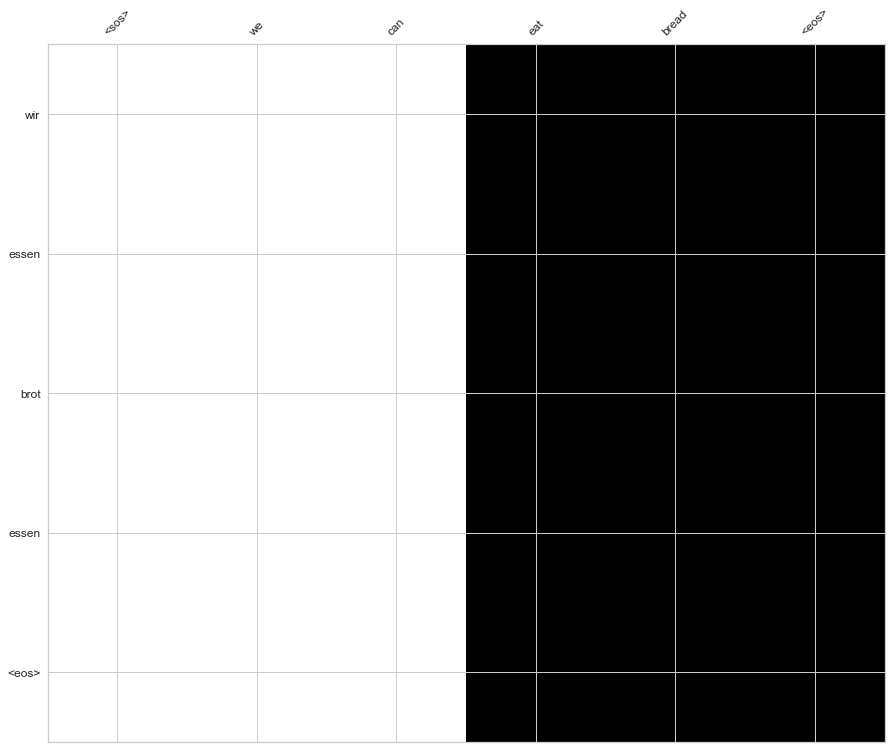

In [83]:
add_new_logger("sample3")
example_idx = 18

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

currentLogger = StepLogger(100)  
translation, attention, all_outputs = translate_sentence(src, SRC, TRG, model, device,is_appy_attention=False)

print(f'predicted trg = {translation}')
 
display_attention(src, translation, attention,n_heads=get_head_count(),n_rows = get_row_count(), n_cols = get_col_count())

In [84]:

for i in range( len(tabular_set)):
    print(" ".join(tabular_set[i].src))
    

i want to eat bread
i want to eat apple
i want to drink water
i want to drink beer
i want to read book
i want to read newspaper
i can eat bread
i can eat apple
i can drink water
i can drink beer
i can read book
i can read newspaper
we want to eat bread
we want to eat apple
we want to drink water
we want to drink beer
we want to read book
we want to read newspaper
we can eat bread
we can eat apple
we can drink water
we can drink beer
we can read book
we can read newspaper
i eat bread
i eat apple
i drink water
i drink beer
i read book
i read newspaper
we eat bread
we eat apple
we drink water
we drink beer
we read book
we read newspaper


In [85]:
tabular_set[i].src


['we', 'read', 'newspaper']

In [86]:
tt = torch.tensor(np.full((1, 2, 1, 6), 1/6) )

att1 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], 3), 1/3) )
att2 = torch.tensor(np.full((tt.shape[0], tt.shape[1], tt.shape[2], tt.shape[3] - 3), 1/7) )
att3 = torch.cat( (att1,att2),3 )
att4 = torch.softmax(att3, dim = -1)
att4

tensor([[[[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]],

         [[0.1825, 0.1825, 0.1825, 0.1508, 0.1508, 0.1508]]]],
       dtype=torch.float64)